In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product

In [2]:
url = 'https://raw.githubusercontent.com/BHAJansen/Individual-porfolio/main/Historical_Data.csv'
data = pd.read_csv(url)

In [3]:
# Check for stationarity
def test_stationarity(timeseries):
    # Perform Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

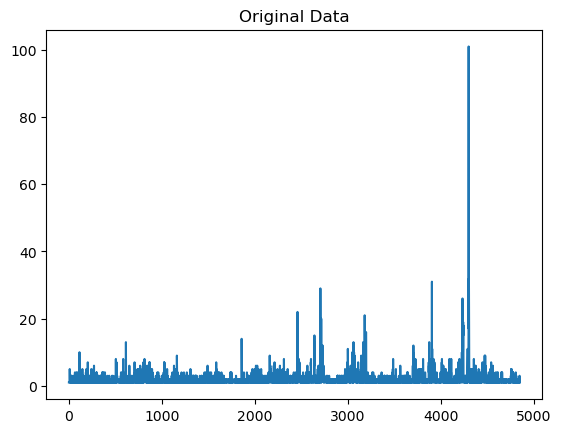

In [4]:
# Plot the original data
plt.plot(data['Sold_Units'])
plt.title("Original Data")
plt.show()

In [5]:
# Print the results of the Dickey-Fuller test for the original data
print("Original Data:")
test_stationarity(data['Sold_Units'])

Original Data:
Results of Dickey-Fuller Test:
Test Statistic                -1.521982e+01
p-value                        5.505206e-28
#Lags Used                     9.000000e+00
Number of Observations Used    4.839000e+03
Critical Value (1%)           -3.431702e+00
Critical Value (5%)           -2.862137e+00
Critical Value (10%)          -2.567088e+00
dtype: float64


In [6]:
# Make data stationary by taking the difference between the current value and the previous value
data['sales_diff'] = data['Sold_Units'] - data['Sold_Units'].shift()

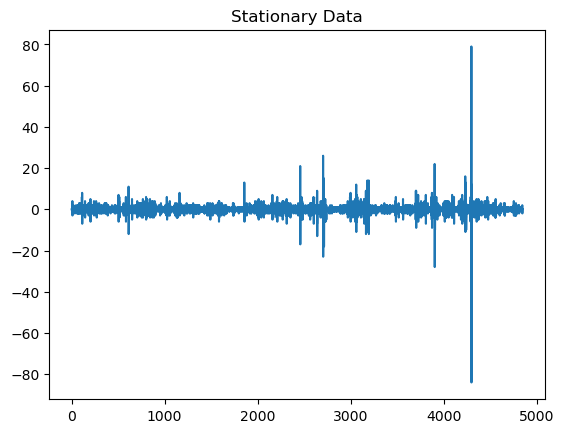

In [7]:
# Plot the stationary data
plt.plot(data['sales_diff'].dropna())
plt.title("Stationary Data")
plt.show()

In [8]:
# Print the results of the Dickey-Fuller test for the stationary data
print("\nStationary Data:")
test_stationarity(data['sales_diff'].dropna())


Stationary Data:
Results of Dickey-Fuller Test:
Test Statistic                  -19.073396
p-value                           0.000000
#Lags Used                       32.000000
Number of Observations Used    4815.000000
Critical Value (1%)              -3.431709
Critical Value (5%)              -2.862140
Critical Value (10%)             -2.567090
dtype: float64


In [9]:
# Define the p, d and q parameters to take any value between 0 and 2
p = d = q = range(0, 2)

In [10]:
# Generate all different combinations of p, q and q triplets
pdq = list(product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [11]:
# Generate all different combinations of seasonal p, q and q triplets
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [12]:
# Find the best ARIMA model
best_aic = float('inf')
best_pdq = None
best_seasonal_pdq = None

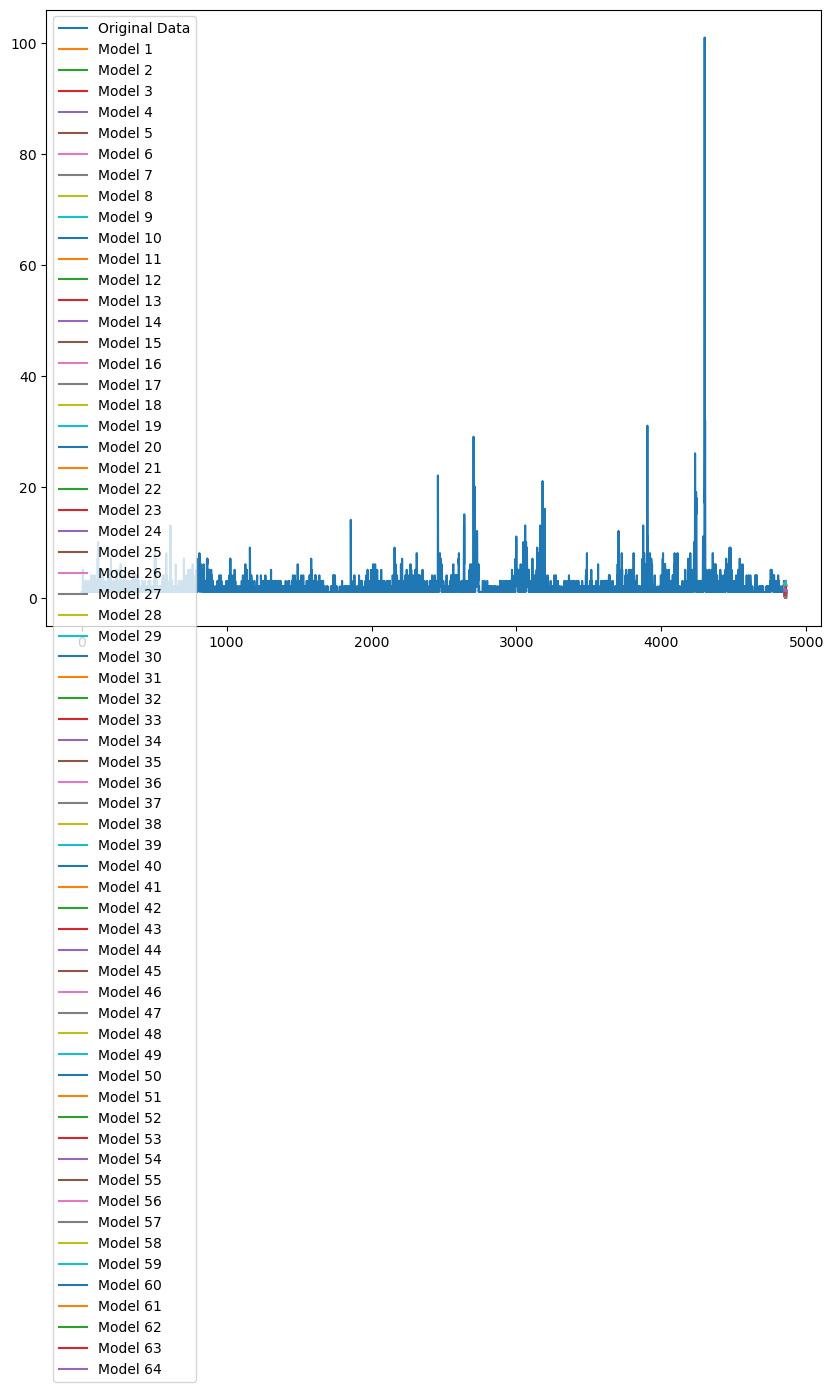

In [13]:
# Initialize a list to store the forecasted values for each model
forecasts = []

# Loop through all possible combinations of p, d, q and seasonal parameters
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            # Fit the SARIMAX model with current parameters
            mod = SARIMAX(data['Sold_Units'], order=param, seasonal_order=param_seasonal, enforce_stationarity=False, enforce_invertibility=False)
            results = mod.fit()

            # Get the forecasted values for the next 12 steps
            forecast = results.forecast(steps=12)
            forecasts.append(forecast)

            # Check if this model has a better AIC than the previous best model
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
        except:
            continue

# Plot the original data and the forecasted values for each model
plt.figure(figsize=(10,8))
plt.plot(data['Sold_Units'], label='Original Data')
for i, forecast in enumerate(forecasts):
    plt.plot(forecast, label=f'Model {i+1}')
plt.legend()
plt.show()

In [15]:
# Print the best SARIMAX model found
print("\nBest SARIMAX{}x{}12 model - AIC:{}".format(best_pdq, best_seasonal_pdq, best_aic))


Best SARIMAX(1, 0, 1)x(0, 1, 1, 12)12 model - AIC:20987.90154386289


In [16]:
# Fit the ARIMA model with the best parameters
model = SARIMAX(data['Sold_Units'], order=best_pdq, seasonal_order=best_seasonal_pdq)
model_fit = model.fit()

In [17]:
# Forecast future sales
forecast = model_fit.forecast(steps=12)

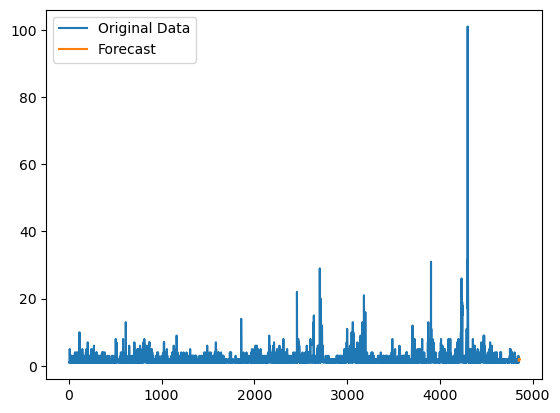

In [18]:
# Plot the original data and forecasted sales
plt.plot(data['Sold_Units'], label='Original Data')
plt.plot(forecast, label='Forecast')
plt.legend()
plt.show()